Drew Lickman

Dr. Barbosa

Project 4, due 10/30/24

AI Disclaimer: 

# Sentiment Analysis with Recurrent Neural Network (RNN Unit)
### Dr. Sal Barbosa, Department of Computer Science, Middle Tennessee State University

In [27]:
# Adjustable variables
max_len 				= 512 	# default: 512, best: 512
trainSplitPercent		= .99 	# default: 0.5, best: 0.99
validationSplitPercent 	= 0.5 # default: 0.5, best: 0.5
batch_size 				= 4 	# default: 8, best: 4
output_dim 				= 6 	# 6 classes
hidden_dim 				= 128 	# Default: 64, best: 128
rtype 					= 'lstm'# Default: rnn, best: gru
n_layers 				= 2 	# Default: 1, best: 2
dropout_rate 			= 0.2 	# Default: 0.1, best: 0.2
bidirectional 			= True 	# Default: False, best: True
epochs 					= 5		# Trial and error: evaluate when validation loss stop decreasing consistently

In [28]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from string import punctuation

import json

# import Word2Vec gensim utilities
from gensim.models import KeyedVectors


### References
> Personal Notes/Projects<br>
> Book Chapters<br>
> <li>D. Jurafsky and J. Martin "Speech and Language Processing (3 Feb 2024 Draft)"</li><br>
> <li>A. Bansal "Advanced Natural Language Processing with TensorFlow 2" (Chapter 2)</li><br>
> <li>D. Rao and B. McMahan "Natural Language Processing with Pytorch" (Chapter 6)</li><br>
> Some approaches and ideas for pre-processing and training/testing were gathered from:<br>
> <li>https://github.com/bentrevett/pytorch-sentiment-analysis/blob/main/2%20-%20Recurrent%20Neural%20Networks.ipynb</li><br>
> <li>https://github.com/cezannec/CNN_Text_Classification/blob/master/CNN_Text_Classification.ipynb</li><br>

---
### Load the Data
---

In [29]:
# Data directory
#DATADIR = "/scratch/user/u.sb157846/data/datasets/cb_speeches/"
DATADIR = "./" # Local speech data

In [30]:
# Read data file
with open(DATADIR + "cb_speeches.txt", encoding='utf8') as f:
    documents = [(story.strip().split('\t')[0].split(), story.strip().split('\t')[1]) for story in f] # Label is documents[1], after the tab in each line in dataset

# documents is a list of 2-tuples consisting of a list of the speech's tokens and its class

# Shuffle the data
#np.random.seed(42)
np.random.shuffle(documents)

In [31]:
# Split documents into speeches and labels
speeches, labels = zip(*documents)
#print(speeches[3735], labels[3735])

---
### Encode labels

As was the case in the custom logistic regression classifier, to use speech labels in the neural network they must be converted from text to integers.

---

In [32]:
countries = {'canada': 0, 'euro area': 1, 'japan': 2, 'sweden': 3, 'united kingdom': 4, 'united states': 5}
encoded_labels = np.array([countries[label] for label in labels])
print(len(speeches), len(encoded_labels))

4240 4240


---
### Using Pre-Trained Word Embeddings (word2vec)

The 300-dimentional word2vec pre-trained embeddings (`GoogleNews-vectors-negative300-SLIM.bin`) are used in this example. However, other pre-trained vectors like <i>Glove</i> or <i>FastText</i> can easily be substituted in their place.

> Set the directory location of vectors in the `EMB_DIR` variable as shown below.

---

In [33]:
# Pre-trained embedding file location
#EMB_DIR = "/scratch/user/u.sb157846/data/word_vectors/GoogleNews-vectors-negative300-SLIM/"
EMB_DIR = "./" # Local directory

# Creating the embeddings matrix
embeddings_table = KeyedVectors.load_word2vec_format(EMB_DIR+'GoogleNews-vectors-negative300-SLIM.bin', binary=True)

---
### Embeddings Matrix

The embeddings matrix in a table, are indexed by a word and contain that word's vector representation. In this example the embedding dimension is 300. The below example show the vector for the word <i>cool</i> is stored at index 512 of the lookup matrix.

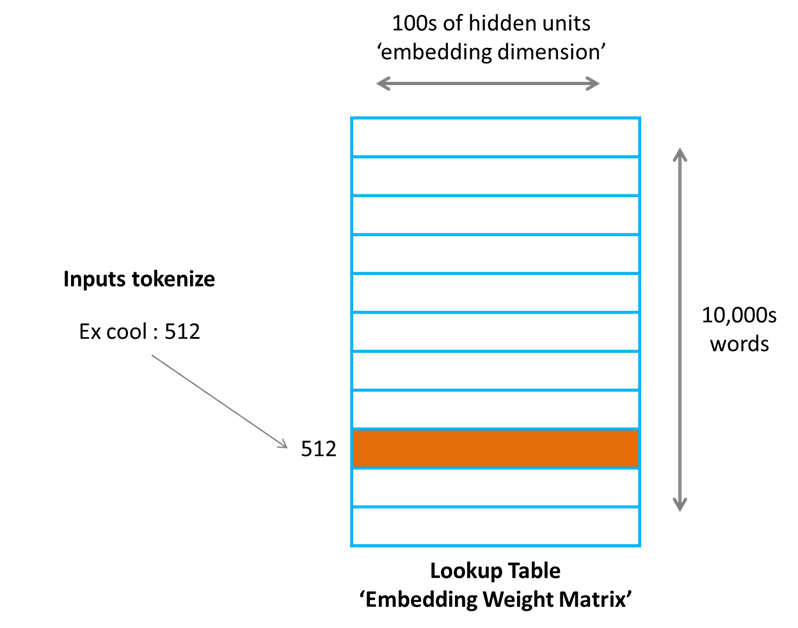

---

In [34]:
# store pretrained vocabulary
pretrained_words = []
for word in embeddings_table.index_to_key:
    pretrained_words.append(word)

In [35]:
row = 0

# vocabulary information
print(f"Vocabulary Size: {len(pretrained_words)}\n")

# word/embedding information
word = pretrained_words[row]                  # words from index
embedding = embeddings_table[word]            # embedding from word
print(f"Embedding Size: {len(embedding)}\n")
print(f"Word in vocab: {word}\n")
#print('Associated embedding: \n', embedding)

Vocabulary Size: 299567

Embedding Size: 300

Word in vocab: in



---
### Converting word tokens to index values
The input to neural networks for a 64-token sequence, for example, is not 64 x embedding dimension. Instead of sending the vectors to words as input, each token's embedding matrix index is sent. The entire embedding matrix is supplied to the network at initialization. During training, when the input is received by the neural network, the translation from indexes (indices) to vectors is done in the embedding layer. The below function converts lists of tokenized speeches to index values.

---

In [36]:
# convert tokens to index values
def tokens_to_index(embeddings_table, speeches):
    indexed_input = [[ embeddings_table.key_to_index[speech_tok] if speech_tok in embeddings_table.key_to_index else 0 
                        for speech_tok in speech] for speech in speeches]
    return indexed_input

In [37]:
indexed_speeches = tokens_to_index(embeddings_table, speeches)

---
### Indexing of a short speech

---

In [38]:
# indexed tokens for a short speech
rev = None
while rev is None:
    rnd_idx = np.random.randint(len(speeches)) # Select a random speech from corpus
    rev = rnd_idx if len(speeches[rnd_idx]) < 150 else None

# print(' '.join(speeches[rev]))
# print()

# for i in range(len(speeches[rev])):
#     print(f"{speeches[rev][i]:<10}{indexed_speeches[rev][i]:>7}", end='\t')
#     if i % 5 == 4:
#         print()
# print()

---
## Padding Speeches

Neural networks generally require that all input have the same dimensions. The speeches, however, have varying lengths. A maximum length of speeches must be chosen after analyzing average and maximum lengths of input as well as model constraints (architecture, memory usage, etc.). This demonstration uses 256 tokens as the maximum length. Any speech longer than this is truncated (tokens beyond 256 are discarded) and shorter speeches are left padded with zeros).

The below function pads all speeches to the maximum length.

---

In [39]:
# This function pads all speeches
def pad_input(tokenized_input, max_len):

    # Get a zero tensor of the correct shape
    features = np.zeros((len(tokenized_input), max_len), dtype=int)

    # Go through each speech and copy the indices into the features list (of padded speeches)
    for i, row in enumerate(tokenized_input):
        try:
            features[i, -len(row):] = np.array(row)[:max_len]
        except:
            print(i, row)
    
    return features

# Instead of padding to a max of 256, could I get the average speech length and pad up to that and truncate down to that? 

In [40]:
#max_len = 512 # Adjustable variable

features = pad_input(indexed_speeches, max_len=max_len)

# Check dimension lengths in resulsing data
assert len(features)==len(features), "Features must have same length as speeches."
assert len(features[0])==max_len, "Each feature row should contain max_len values."

#print(features[:25,:10])

---
## Split Data into Training, Validation, and Test

The data must be split into training and test data minimally. Many training loops can also use validation data at the end of each epoch, allowing a comparison between training and validation losses (if this value is high or growing it may indicate overfitting).

The split for this demonstration will be 80% training and 10% each for test and validation.

---

In [41]:
# training/test split (validation will come from test portion)
tt_split = int(len(features) * trainSplitPercent)

train_x, valtest_x = features[:tt_split], features[tt_split:]
train_y, valtest_y = encoded_labels[:tt_split], encoded_labels[tt_split:]

# Validation/test split (further split test data into validation and test)
vt_split = int(len(valtest_x)*validationSplitPercent) # Default 0.5
val_x, test_x = valtest_x[:vt_split], valtest_x[vt_split:]
val_y, test_y = valtest_y[:vt_split], valtest_y[vt_split:]

## Show shapes of data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
		"\nValidation set: \t{}".format(val_x.shape),
		"\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(3392, 512) 
Validation set: 	(424, 512) 
Test set: 		(424, 512)


## Batching and DataLoaders

Neural networks work best when data is processed in batches. This reduces convergence time through calculating and applying the average of losses and gradients of properly sized batches (compared to single input processing or full batch processing, which may not fit in memory).

PyTorch provides utilities for creating and managing batched data. The data is placed into Datasets, and Dataloaders are used to shuffle the data (if desired) and break it up into batches. This is carried out below for the traininng, validation, and test splits.

---

In [42]:
# create Tensor datasets
train_data 		= TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y).long())
valid_data 		= TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y).long())
test_data 		= TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y).long())
# Had to convert to .long() type so the code would function

# dataloaders
#batch_size 		= 4 # default: 8, best: 4

# shuffling and batching data
train_loader 	= DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader 	= DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader 	= DataLoader(test_data, shuffle=True, batch_size=batch_size)

---
### The model
The neural network model below is a simple RNN-module based recurrent neural network.

---

In [43]:
class MulticlasRNN(nn.Module):
	def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, rtype, n_layers, dropout_rate, 
				bidirectional=False, embed_model=None, freeze_embeddings=True):
				
		super(MulticlasRNN, self).__init__()

		# Network Layers
		
		# Embedding Layer
		self.embedding = nn.Embedding(vocab_size, embedding_dim)

		# If pre-trained vectors are defined load the weights
		if embed_model is not None:
			print("Loading pre-trained vectors")
			self.embedding.weight = nn.Parameter(torch.from_numpy(embed_model.vectors)) # all vectors

			# freeze embedding weights (since we're not fine-tuning them)
			if freeze_embeddings:
				print("Freezing pre-trained vectors")
				self.embedding.requires_grad = False

		# RNN Layer
		if rtype == 'gru':
			self.rnn = nn.GRU(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional, dropout=dropout_rate, batch_first=True)
		elif rtype == 'lstm':
			self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional, dropout=dropout_rate if n_layers > 1 else 0, batch_first=True)
		else:
			self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional, dropout=dropout_rate, batch_first=True)

		# ReLU Activation Layer
		self.relu = nn.ReLU()

		# First fully connected layer
		self.fc = nn.Linear(hidden_dim, hidden_dim)
		# Second fully connected layer
		#self.fc = nn.Linear(hidden_dim, output_dim)

		# Dropout Layer
		self.dropout = nn.Dropout(dropout_rate)

	def forward(self, x):
		batch_size = x.size(0)

		# Convert token index values to vector embeddings
		embedded = self.embedding(x)

		# Pass embeddings to RNN and get back output and hidden state
		out, hidden = self.rnn(embedded)

		# Handle different hidden state formats for LSTM vs GRU/RNN
		if isinstance(hidden, tuple):  # LSTM case
			hidden_state = hidden[0][-1]  # Get just the hidden state, ignore cell state
		else:  # GRU/RNN case
			hidden_state = hidden[-1]

		# Pass the hidden state of the last time step to the rest of the classifier (can dropout explicitly)
		# if n_layers == 1:
		# 	x_do_out = hidden[-1,:,:]              # use if single layer - no droput applied
		# else:
		# 	x_do_out = self.dropout(hidden[-1,:,:]) # use if multiple layer, apply droput
		
		# Apply dropout if multiple layers
		if n_layers > 1:
			hidden_state = self.dropout(hidden_state)

		# Then the fully-connected layer
		#logit = self.fc(x_do_out)
		logit = self.fc(hidden_state)


		return logit


---
### Model Parameters

---

In [44]:
# General parameters
vocab_size = len(pretrained_words)
#output_size = 1 # binary class (1 or 0)
embedding_dim = len(embeddings_table[pretrained_words[0]]) # 300-dim vectors

---
### Neural Network Hyperparameters

---

In [45]:
# RNN-specific parameters
# output_dim = 6
# hidden_dim = 128 		# Default: 64, best: 128
# rtype = 'gru' 			# Default: rnn, best: gru
# n_layers = 2 			# Default: 1, best: 2
# dropout_rate = 0.2 		# Default: 0.1, best: 0.2
# bidirectional = True 	# Default: False, best: True
emb = embeddings_table	# Default: embeddings_table, best: embeddings_table	# embeddings_table or None
freeze = True			# Default: True, best: True 						# Only False if emb = None

# Instantiate RNN model # send embeddings_table in place of None
rnn_model = MulticlasRNN(vocab_size, embedding_dim, hidden_dim, output_dim, rtype, n_layers, dropout_rate,
                         bidirectional=bidirectional, embed_model=emb, freeze_embeddings=freeze)


Loading pre-trained vectors
Freezing pre-trained vectors


---
### Training

---

In [46]:
# Device
import torch.version

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [47]:
# Model loss and optimizer 
rnn_lr = 5e-4
rnn_criterion = nn.CrossEntropyLoss() #Multiclass so can't use nn.BCELoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=rnn_lr)

In [48]:
# Instantiate the model
rnn_model = rnn_model.to(device)

---
### Training Loop

---

In [49]:
# Training loop
def rnn_train(net, train_loader, epochs, print_every=100):

    # Move model to GPU/CPU
    net.to(device)

    counter = 0 # for printing
    
    # Place model in training mode
    net.train()

    # Train for some number of epochs
    for e in range(epochs):

        # batch loop
        for inputs, labels in train_loader:
            counter += 1

            # Move training data batch to GPU/CPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero out gradients
            net.zero_grad()

            # Get the output from the model
            output = net(inputs)

            # Calculate the loss
            loss = rnn_criterion(output, labels)

            # Backpropagate
            loss.backward()

            # Update weights
            rnn_optimizer.step()

            # Validation
            if counter % print_every == 0:

                # Get validation loss
                val_losses = []

                # Place model in evaluation mode (weights are not updated)
                net.eval()

                # Go through validation set
                for inputs, labels in valid_loader:

                    # Move validation data batch to GPU/CPU
                    inputs, labels = inputs.to(device), labels.to(device)
                    # get predicted label
                    output = net(inputs)

                    # Calculate validation loss
                    #val_loss = rnn_criterion(output.squeeze(), labels.float())
                    val_loss = rnn_criterion(output, labels)

                    # Retain for average calculation
                    val_losses.append(val_loss.item())

                # Place model back in training mode
                net.train()

                # Output losses
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Train Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))

In [50]:
# Clear GPU memory before taining
if device == 'cuda':
    torch.cuda.empty_cache()

In [51]:
# Training parameters and invoking training
#epochs = 5        # Trial and error: evaluate when validation loss stop decreasing consistently
print_every = 100
rnn_train(rnn_model, train_loader, epochs, print_every=print_every)

Epoch: 1/5... Step: 100... Train Loss: 1.804331... Val Loss: 1.850989
Epoch: 1/5... Step: 200... Train Loss: 1.727004... Val Loss: 1.804312
Epoch: 1/5... Step: 300... Train Loss: 1.696428... Val Loss: 1.796819
Epoch: 1/5... Step: 400... Train Loss: 1.739645... Val Loss: 1.800629
Epoch: 1/5... Step: 500... Train Loss: 1.655430... Val Loss: 1.801308
Epoch: 1/5... Step: 600... Train Loss: 1.846988... Val Loss: 1.778037
Epoch: 1/5... Step: 700... Train Loss: 2.010466... Val Loss: 1.703708
Epoch: 1/5... Step: 800... Train Loss: 1.015436... Val Loss: 1.647908
Epoch: 2/5... Step: 900... Train Loss: 1.690164... Val Loss: 1.658644
Epoch: 2/5... Step: 1000... Train Loss: 1.133597... Val Loss: 1.612059
Epoch: 2/5... Step: 1100... Train Loss: 1.125189... Val Loss: 1.597749
Epoch: 2/5... Step: 1200... Train Loss: 1.631296... Val Loss: 1.587791
Epoch: 2/5... Step: 1300... Train Loss: 1.927499... Val Loss: 1.592488
Epoch: 2/5... Step: 1400... Train Loss: 1.619190... Val Loss: 1.552874
Epoch: 2/5... S

---
## Testing the Model

---

In [52]:
#Testing loop
def rnn_test(test_loader):
    # Turn off gradient calculations (saves time and compute resources)
    with torch.no_grad():
    
        # Variables for tracking losses
        test_losses = [] 
        num_correct = 0
    
        true_list = []
        pred_list = []
    
        # Place model in evaluation mode
        rnn_model.eval()
    
        # Run test data through model
        for inputs, labels in test_loader:
    
            # Move test data batch to GPU/CPU
            inputs, labels = inputs.to(device), labels.to(device)
    
            # Get predicted output
            output = rnn_model(inputs)
    
            # Calculate the loss
            # test_loss = rnn_criterion(output.squeeze(), labels.float())
            test_loss = rnn_criterion(output.squeeze(), labels)
            test_losses.append(test_loss.item())
    
            # Convert output sigmoid probabilities to predicted classes (0 or 1)
            #pred = torch.round(output.squeeze())  # rounds to the nearest integer
            pred = torch.argmax(output, dim=1)
    
            # Place true and predicted labels in list
            true_list += list(labels.cpu().numpy())
            pred_list += list(pred.cpu().numpy())
    
            # Compare predicted and true labels and count number of correct prediction
            correct_tensor = pred.eq(labels.float().view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if device=='cpu' else np.squeeze(correct_tensor.cpu().numpy())
            num_correct += np.sum(correct)
    
    pred_list = [a.squeeze().tolist() for a in pred_list]
    print(confusion_matrix(true_list, pred_list))
    print()
    print(classification_report(true_list, pred_list))
    print()
    print(f"Accuracy {accuracy_score(true_list, pred_list):.2%}")
    
    # Output average test loss
    print("Test loss: {:.3f}".format(np.mean(test_losses)))
    
    # Output average accuracy
    test_acc = num_correct/len(test_loader.dataset)
    print("Test accuracy: {:.3f}".format(test_acc))

rnn_test(test_loader)

[[46  3  0  2  6  9]
 [ 1 55  2  4  1  2]
 [ 1  0 61  2  0  1]
 [ 1  7  3 10  1 39]
 [ 1 17  3  8 32 23]
 [ 4  3  8  5  3 60]]

              precision    recall  f1-score   support

           0       0.85      0.70      0.77        66
           1       0.65      0.85      0.73        65
           2       0.79      0.94      0.86        65
           3       0.32      0.16      0.22        61
           4       0.74      0.38      0.50        84
           5       0.45      0.72      0.55        83

    accuracy                           0.62       424
   macro avg       0.63      0.62      0.61       424
weighted avg       0.63      0.62      0.60       424


Accuracy 62.26%
Test loss: 1.069
Test accuracy: 0.623
